# DonorsChoose - Diego Preciado Barón - ms700162

Nota: El dataset proporcionado esta reducido (Projects y Donations). El dataset completo se encuentra en el siguiente link: https://www.kaggle.com/donorschoose/io#Donors.csv

In [1]:
import nltk
# nltk.download('wordnet')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from wordcloud import WordCloud
import re
import math
from collections import defaultdict
from warnings import warn
from scipy import spatial
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
import random
from pylab import bone, pcolor, colorbar, plot, show

%matplotlib inline

In [2]:
my_stop_words = ["of","the", "what", "where", "how", "when", "why", "as", "there" ,"are", "is", "and", "or", "school", "to",
                 "for", "it", "i", "they", "however", "then", "we", "on", "help", "us", "oh", "please", "students", "student",
                "my", "in","into","onto","me","can", "be","you", "from", "by", "an", "at", "that", "so","could","up","right",
                 "left", "more", "less", "down", "who", "but", "would", "donotremoveessaydivid"]

stop_words_ = stopwords.words('english')
stop_words_.extend(my_stop_words) # Add new stop words

def update_name_columns(df):
    df.columns = [col.replace(" ", "_").lower() for col in df.columns]
    return df

#For WordCloud
def tokenize(docs):
        tokenizer = RegexpTokenizer(r'\w+')
        lemma = WordNetLemmatizer()
        
        for idx in range(len(docs)):
            docs[idx] = docs[idx].lower() # Convert to lowercase.
            docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.
            
        # Remove numbers, but not words that contain numbers.
        docs = [[token for token in doc if not token.isnumeric()] for doc in docs]
        
        # Remove words that are only one character.
        docs = [[token for token in doc if len(token) > 1] for doc in docs]
        
        # Remove Non-ASCII characters.
        docs = [[token for token in doc if not re.search('[^A-Za-z0-9]',token)] for doc in docs]
        
        # Remove stop-words and lemmatize
        docs = [[lemma.lemmatize(token) for token in doc if token not in stop_words_] for doc in docs]
        
        return docs
    
#For TF-IDIF
def tokenize_(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if not token.isnumeric()]
    tokens = [token for token in tokens if not re.search('[^A-Za-z0-9]',token)]
    tokens = [token for token in tokens if token not in stop_words_]
    stems = []
    for item in tokens:
        item = item.lower()
        stems.append(PorterStemmer().stem(item))
    return stems

def start_lemmatizer():
    lemma = WordNetLemmatizer() 
    l = ["reading", "was"]
    return lemma.lemmatize(l[0])
    
def get_dict_and_corpus(docs):
    # Create a dictionary representation of the documents.
    dictionary = Dictionary(docs) #Gets all the unique words and assigns an ID
    # Filter out words that occur less than 20 documents, or more than 50% of the documents.
#     dictionary.filter_extremes(no_below=20, no_above=0.5)
    # Bag-of-words representation of the documents. For each document adds (WordID, Frequency)
    corpus = [dictionary.doc2bow(doc) for doc in docs ]
    return dictionary, corpus

def get_string_for_word_cloud(docs):
    string = ""
    for doc in docs:
        for word in doc:
            string += ', ' + word
    return string

def get_state_match(seq):
    users_list = search_for_n_donations(seq)
    donations_seq = donations[donations['donor_id'].isin(users_list)][['project_id', 'donor_id']]
#     donations_seq = donations.loc[donations["donor_cart_sequence"] == seq][['project_id', 'donor_id']]
    
    lproject = projects[['project_id','school_id']]
    lschools = schools[['school_id','school_state']]
    project_school = pd.merge(lproject, lschools, on = 'school_id')
    
    ldonors = donors[['donor_id','donor_state']]
    donations_donors = pd.merge(donations_seq, ldonors, on = 'donor_id')
    
    project_states = pd.merge(donations_donors, project_school, on = 'project_id')
    project_states['same_state'] = project_states['donor_state'] == project_states['school_state']
    values = project_states['same_state'].value_counts()
    perc = round(values[1]/(values[0] + values[1]) * 100, 2)
    
    return perc

#Search for donors with n donations
def search_for_n_donations(n_don = 1):
    x = []
    s_d = donations['donor_id'].value_counts()
    for keys, value in s_d.items():
        if value == n_don:
            x.append(keys)
    return x

In [3]:
projects = pd.read_csv("Data/Projects.csv")
schools = pd.read_csv("Data/Schools.csv")
donors = pd.read_csv("Data/Donors.csv")
donations = pd.read_csv("Data/Donations.csv")

# resources = pd.read_csv("Data/Resources.csv") #NOT USED
# teachers = pd.read_csv("Data/Teachers.csv") #NOT USED
projects = update_name_columns(projects)
donations = update_name_columns(donations)
donors = update_name_columns(donors)
schools = update_name_columns(schools)


C:\Users\uidv7259\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# projects_1000 = projects[:1000]
# donations_1000 = donations[:1000]

# projects_1000.to_csv('projects_1000.csv', index=False)
# donations_1000.to_csv('donations_1000.csv', index=False)

# Projects

In [4]:
projects.head()

,project_id,school_id,teacher_id,teacher_project_posted_sequence,project_type,project_title,project_essay,project_short_description,project_need_statement,project_subject_category_tree,project_subject_subcategory_tree,project_grade_level_category,project_resource_category,project_cost,project_posted_date,project_expiration_date,project_current_status,project_fully_funded_date
0,7685f0265a19d7b52a470ee4bac883ba,e180c7424cb9c68cb49f141b092a988f,4ee5200e89d9e2998ec8baad8a3c5968,25,Teacher-Led,Stand Up to Bullying: Together We Can!,Did you know that 1-7 students in grades K-12 ...,Did you know that 1-7 students in grades K-12 ...,"My students need 25 copies of ""Bullying in Sch...",Applied Learning,"Character Education, Early Development",Grades PreK-2,Technology,361.80,2013-01-01,2013-05-30,Fully Funded,2013-01-11
1,f9f4af7099061fb4bf44642a03e5c331,08b20f1e2125103ed7aa17e8d76c71d4,cca2d1d277fb4adb50147b49cdc3b156,3,Teacher-Led,Learning in Color!,"Help us have a fun, interactive listening cent...","Help us have a fun, interactive listening cent...","My students need a listening center, read alon...","Applied Learning, Literacy & Language","Early Development, Literacy",Grades PreK-2,Technology,512.85,2013-01-01,2013-05-31,Expired,NaN
2,afd99a01739ad5557b51b1ba0174e832,1287f5128b1f36bf8434e5705a7cc04d,6c5bd0d4f20547a001628aefd71de89e,1,Teacher-Led,Help Second Grade ESL Students Develop Languag...,Visiting or moving to a new place can be very ...,Visiting or moving to a new place can be very ...,My students need beginning vocabulary audio ca...,Literacy & Language,ESL,Grades PreK-2,Supplies,435.92,2013-01-01,2013-05-30,Fully Funded,2013-05-22
3,c614a38bb1a5e68e2ae6ad9d94bb2492,900fec9cd7a3188acbc90586a09584ef,8ed6f8181d092a8f4c008b18d18e54ad,40,Teacher-Led,Help Bilingual Students Strengthen Reading Com...,Students at our school are still working hard ...,Students at our school are still working hard ...,My students need one copy of each book in The ...,Literacy & Language,"ESL, Literacy",Grades 3-5,Books,161.26,2013-01-01,2013-05-31,Fully Funded,2013-02-06
4,ec82a697fab916c0db0cdad746338df9,3b200e7fe3e6dde3c169c02e5fb5ae86,893173d62775f8be7c30bf4220ad0c33,2,Teacher-Led,Help Us Make Each Minute Count!,"""Idle hands"" were something that Issac Watts s...","""Idle hands"" were something that Issac Watts s...","My students need items such as Velcro, two pou...",Special Needs,Special Needs,Grades 3-5,Supplies,264.19,2013-01-01,2013-05-30,Fully Funded,2013-01-01


In [5]:
projects['project_posted_date'] = pd.to_datetime(projects['project_posted_date'], format = "%Y-%m-%d")
projects['project_expiration_date'] = pd.to_datetime(projects['project_expiration_date'], format = "%Y-%m-%d")
projects['project_fully_funded_date'] = pd.to_datetime(projects['project_fully_funded_date'], format = "%Y-%m-%d")
#Tokenize: Remove numbers, but not words that contain numbers, Remove words that are only one character

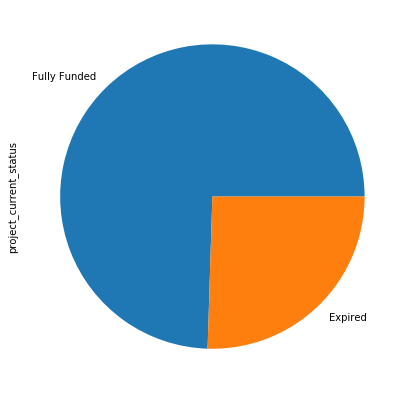

In [6]:
status = projects['project_current_status'].value_counts()
status.plot.pie( figsize = (7,7));

In [7]:
monthly_projects = projects[['project_posted_date', 'project_id']]
monthly_projects.set_index(['project_posted_date'], inplace = True)
monthly_projects = monthly_projects.resample('M').count()

C:\Users\uidv7259\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1095: UserWarning: Attempting to set identical left == right == 516.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


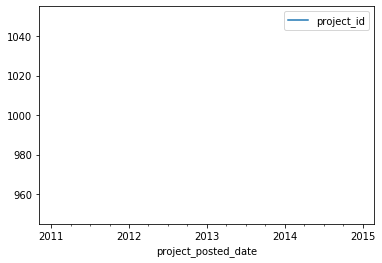

In [8]:
monthly_projects.plot()

In [9]:
project_dates_2013 = monthly_projects[monthly_projects.index.year == 2013]
project_dates_2014 = monthly_projects[monthly_projects.index.year == 2014]
project_dates_2015 = monthly_projects[monthly_projects.index.year == 2015]
project_dates_2016 = monthly_projects[monthly_projects.index.year == 2016]
project_dates_2017 = monthly_projects[monthly_projects.index.year == 2017]
project_dates_2018 = monthly_projects[monthly_projects.index.year == 2018]

C:\Users\uidv7259\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1095: UserWarning: Attempting to set identical left == right == 516.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


ValueError: zero-size array to reduction operation fmin which has no identity

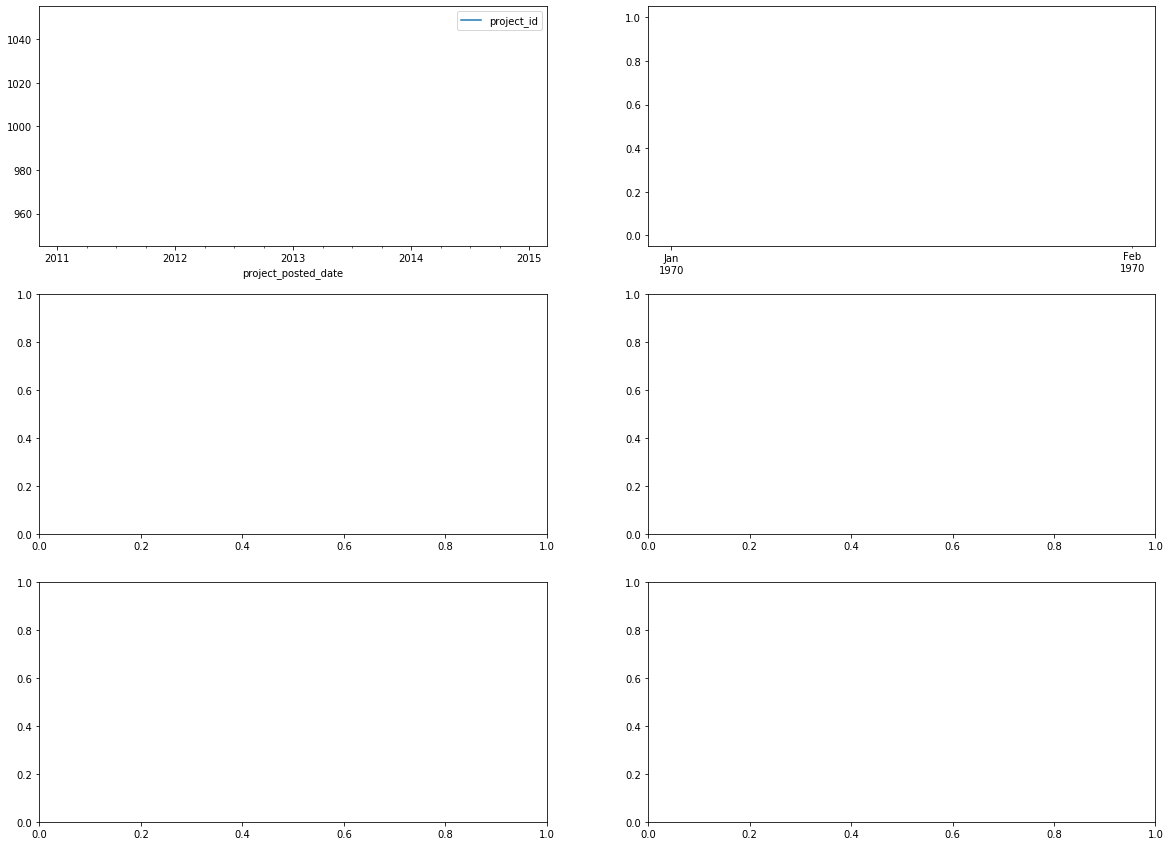

In [10]:
fig, axes = plt.subplots(nrows = 3, ncols=2, figsize=(20,15))
project_dates_2013.plot(ax = axes[0,0]);
project_dates_2014.plot(ax = axes[0,1]);
project_dates_2015.plot(ax = axes[1,0]);
project_dates_2016.plot(ax = axes[1,1]);
project_dates_2017.plot(ax = axes[2,0]);
project_dates_2018.plot(ax = axes[2,1]);

### WordCloud - Projects

In [ ]:
projects['project_title'].dropna(inplace = True)
projects['project_title'].isnull().sum()
titles = tokenize(projects['project_title'].tolist())
titles = get_string_for_word_cloud(titles)

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(titles) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Donors

In [ ]:
donors.head()

In [ ]:
porc =  (donors["Donor City"].isnull().sum()/donors.shape[0]) * 100
print("Porcentaje de Donors City faltante: {0} %".format(round(porc, 2)))

# Donations

In [34]:
donations.head()

,project_id,donation_id,donor_id,donation_included_optional_donation,donation_amount,donor_cart_sequence,donation_received_date
0,000009891526c0ade7180f8423792063,688729120858666221208529ee3fc18e,1f4b5b6e68445c6c4a0509b3aca93f38,No,178.37,11,2016-08-23 13:15:57
1,000009891526c0ade7180f8423792063,dcf1071da3aa3561f91ac689d1f73dee,4aaab6d244bf3599682239ed5591af8a,Yes,25.00,2,2016-06-06 20:05:23
2,000009891526c0ade7180f8423792063,18a234b9d1e538c431761d521ea7799d,0b0765dc9c759adc48a07688ba25e94e,Yes,20.00,3,2016-06-06 14:08:46
3,000009891526c0ade7180f8423792063,38d2744bf9138b0b57ed581c76c0e2da,377944ad61f72d800b25ec1862aec363,Yes,25.00,1,2016-05-15 10:23:04
4,000009891526c0ade7180f8423792063,5a032791e31167a70206bfb86fb60035,6d5b22d39e68c656071a842732c63a0c,Yes,25.00,2,2016-05-17 01:23:38


In [ ]:
donations.donation_received_date = pd.to_datetime(donations.donation_received_date, format = "%Y-%m-%d")
donations_sequence = donations[['project_id', 'donor_id', 'donor_cart_sequence']]
donations_1 = donations_sequence.loc[donations_sequence['donor_cart_sequence'] == 1]
donations_1.head()

In [ ]:
monthly_donations = donations[['donation_received_date', 'donation_id']]
monthly_donations.set_index(['donation_received_date'], inplace = True)
monthly_donations = monthly_donations.resample('M').count()

In [ ]:
monthly_donations.plot();

In [ ]:
dates_2013 = monthly_donations[monthly_donations.index.year == 2013]
dates_2014 = monthly_donations[monthly_donations.index.year == 2014]
dates_2015 = monthly_donations[monthly_donations.index.year == 2015]
dates_2016 = monthly_donations[monthly_donations.index.year == 2016]
dates_2017 = monthly_donations[monthly_donations.index.year == 2017]
dates_2018 = monthly_donations[monthly_donations.index.year == 2018]

In [ ]:
fig, axes = plt.subplots(nrows = 3, ncols=2, figsize=(20,15))
dates_2013.plot(ax = axes[0,0]);
dates_2014.plot(ax = axes[0,1]);
dates_2015.plot(ax = axes[1,0]);
dates_2016.plot(ax = axes[1,1]);
dates_2017.plot(ax = axes[2,0]);
dates_2018.plot(ax = axes[2,1]);

In [41]:
# donations_hist = donations['donor_cart_sequence'].value_counts()
n_donations = donations['donor_id'].value_counts()

donations_hist_1 = search_for_n_donations(1)
print("Donations Mean: ", n_donations.mean())
donations_1 = len(n_donations) - len(donations_hist_1)
perc = donations_1/len(n_donations)
print("Porcentaje donadores con mas de una donacion:", round(perc*100,2))

Donations Mean:  2.3155144293508596
Porcentaje donadores con mas de una donacion: 27.31


In [ ]:
best = donations.loc[donations['donor_cart_sequence'] == 17256]['donor_id']
donations.loc[donations['donor_id'] == best.values[0]]

In [ ]:
best = donations.loc[17256]['donor_id']
# donations.loc[donations['donor_id'] == best.values[0]]

# Schools

In [ ]:
schools.head()

# Resources

In [ ]:
# resources.info();
# resources.head()

# Teachers

In [ ]:
# teachers.info();
# teachers.head()

# Relationship

In [ ]:
seqs = range(1,11)
y = []
for i in seqs:
    y.append(get_state_match(i))

In [ ]:
fig, ax = plt.subplots()
bar1 = ax.bar(seqs,y);
ax.set_ylabel('Percentage')
ax.set_xlabel('# Donations')


# TF-IDF

1) Create vocabulary
2) tf(t,d) = count of t in d / number of words in d
3) df(t) = occurrence of t in documents
4) idf(t) = log(N/(df + 1))
5) tf-idf(t, d) = tf(t, d) * log(N/(df + 1))

In [16]:
essays = projects['project_essay'].tolist()
test_essays = essays[:1000]

In [17]:
tfidf = TfidfVectorizer(tokenizer = tokenize_)
# tokenize and build vocab
X = tfidf.fit_transform(test_essays)
# print(tfidf.vocabulary_)


# SOM

In [8]:
def scaling(X):
    Xs = (X - np.min(X, axis=0))/(np.max(X, axis=0)-np.min(X, axis=0))
    return Xs

def inv_scaling(Xs, vmax, vmin):
    X = Xs*(vmax-vmin)+vmin
    return X

def add_id(x):
    np_id = np.arange(x.shape[0])
    np_id_s = scaling(np_id)
    return np.c_[np_id_s, x]

def norm(X):
    return math.sqrt(np.dot(X, X.T))

def cosine_distance(x, y):
    return 1.0 - np.dot(x,y)/(norm(x)*norm(y))

# Inicialicemos los pesos del SOM tomando ejemplos aleatorios de los datos
def init_weights(data, x_dim, y_dim, input_len, activation_map):
    random_generator = np.random.RandomState(random_seed)
    W = random_generator.rand(x_dim, y_dim, input_len)*2-1
    it = np.nditer(activation_map, flags=['multi_index'])
    while not it.finished:
        W[it.multi_index] = data[random_generator.randint(len(data))]
        W[it.multi_index] = W[it.multi_index]/norm(W[it.multi_index])
        it.iternext()
    return W

def gaussian(c, sigma):
    """ Returns a Gaussian centered in c (i,j) """
    d = 2*math.pi*sigma*sigma # Por que pi? En la formula de la presentación no viene
    neigx = np.arange(x_dim)
    neigy = np.arange(y_dim)
    ax = np.exp(-np.power(neigx-c[0], 2)/d) #[0, 1, 2...] - 2(i) = [-2, -1, 0, 1, 2...]
    ay = np.exp(-np.power(neigy-c[1], 2)/d) #[0, 1, 2...] - 1(j) = [-1, 0, 1, 2, 3...]
    return np.outer(ax, ay)  # the external product gives a matrix


def update(x, W, win, t, T):
    """
        Updates the weights of the neurons.
        x - current pattern to learn (got from random sample)
        win - position of the winning neuron for x (array or tuple).
        t - iteration index
    """
    eta = decay_function(learning_rate, t, T)
    sig = decay_function(sigma, t, T) # sigma and learning rate decrease with the same rule
    g = gaussian(win, sig)*eta # improves the performances
    it = np.nditer(g, flags=['multi_index'])
    while not it.finished:
        # eta * neighborhood_function * (x-w)
        W[it.multi_index] += g[it.multi_index]*(x-W[it.multi_index])
        # normalization
        W[it.multi_index] = W[it.multi_index] / norm(W[it.multi_index])
        it.iternext()
    return W


# 4
def winner(x, activation_map):
    """ Computes the coordinates of the winning neuron for the sample x """
    activation_map=activate(x, W, activation_map) # It sets the distance between x and w on each neuron
    return np.unravel_index(activation_map.argmin(), activation_map.shape) #Return the position (i,j) of the min distance value

# 3
def activate(x, W, activation_map):
    """ Updates matrix activation_map, in this matrix the element i,j is the response of the neuron i,j to x """
    """ Returns the activation map to x """
#     s = np.subtract(x, W) # x(1540) - w(shape 5,5,1540)
    it = np.nditer(activation_map, flags=['multi_index'])
    while not it.finished:
#         activation_map[it.multi_index] = norm(s[it.multi_index])  # || x - w ||
        activation_map[it.multi_index] = cosine_distance(x, W[it.multi_index])
        it.iternext()
    return activation_map

# 2
def init_T(num_iterations):
    T = num_iterations/2    
    return T

# 1        
def train_random(data, num_iterations, W, activation_map):
    """ Trains the SOM picking samples at random from data """
    T=init_T(num_iterations)
    for iteration in range(num_iterations):
        rand_i = random_generator.randint(len(data)) # pick a random sample
        W=update(data[rand_i], W, winner(data[rand_i], activation_map), iteration, T)
    return W

# Mapa de distancias
def distance_map(W):
    """ Returns the distance map of the weights.
        Each cell is the normalised sum of the distances between a neuron and its neighbours.
    """
    dm = np.zeros((W.shape[0], W.shape[1]))
    it = np.nditer(dm, flags=['multi_index'])
    while not it.finished:
        for ii in range(it.multi_index[0]-1, it.multi_index[0]+2):
            for jj in range(it.multi_index[1]-1, it.multi_index[1]+2):
                if ii >= 0 and ii < W.shape[0] and jj >= 0 and jj < W.shape[1]:
                    dm[it.multi_index] += norm(W[ii, jj, :]-W[it.multi_index])
        it.iternext()
    dm = dm/dm.max()
    return dm

def win_map(data):
    """
        Returns a dictionary wm where wm[(i,j)] is a list with all the patterns (or samples from data table)
        that have been mapped in the position i,j.
    """
    winmap = defaultdict(list)
    for x in data:
        winmap[winner(x, activation_map)].append(x)
    return winmap

In [32]:
#Mapa de activación
# 5*sqr(N) N = training samples
Xr = X.toarray()
Xr= add_id(Xr)
n_neurons = 5*np.sqrt(Xr.shape[0])
x_dim = int(np.sqrt(n_neurons))
y_dim = int(np.sqrt(n_neurons))
input_len=Xr.shape[1]

#tamaño del vecindario (Gausiano), necesita adecuarse al tamaño del mapa.
sigma = 1.2

#Learning rate inicial
learning_rate =0.5

#decay function
decay_function = lambda x, t, max_iter: x/(1+t/max_iter)

#Semilla ha utilizar
random_seed = 2

#Para validar el valor de sigma
if sigma >= x_dim/2.0 or sigma >= y_dim/2.0:
    warn('Cuidado: sigma es muy alto para las dimensiones del mapa.')
    
random_generator = np.random.RandomState(random_seed)

In [33]:
n_iterations = Xr.shape[0]
activation_map = np.zeros((x_dim, y_dim))
W=init_weights(Xr, x_dim, y_dim, input_len, activation_map)
Wf=train_random(Xr, n_iterations, W, activation_map)
map_ = win_map(Xr)

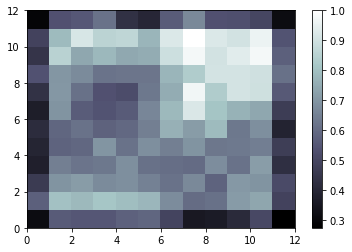

In [42]:
bone()
pcolor(distance_map(Wf).T)

colorbar()

for i, x in enumerate(Xr):
    w=winner(x, activation_map)
    plot(w[0] + 0.5, 
         w[1] + 0.5)
show()

# Recommendation System

Nota: se tomaron un total de N ensayos de diferentes años para probar el sistema de recomendación, pero en realidad se tomarían solo los proyectos que estén vigentes ya que este conjunto de datos no está actualizado, todos los proyectos en la tabla se encontrarían expirados.

In [11]:
#
def create_project_state(seq):
    users_list = search_for_n_donations(seq)
    donations_seq = pd.DataFrame({'donor_id': users_list})
    
    ldonors = donors[['donor_id','donor_state']]
    donations_donors_state = pd.merge(donations_seq, ldonors, on = 'donor_id')
    
    lproject = projects[['project_id','school_id']]
    lschools = schools[['school_id','school_state']]
    project_school_state = pd.merge(lproject, lschools, on = 'school_id')
    
    return donations_donors_state, project_school_state

#Check if project and donor are from same state - 1st priority
def same_state(donor_id, proj_id, df_donors, df_projects):
    donor_state = df_donors[df_donors['donor_id'] == donor_id]['donor_state'].values[0]
    project_state = df_projects[df_projects['project_id'] == proj_id]['school_state'].values[0]
    
    return donor_state == project_state

def priority_list(donor_id, similar_ids, d_states, s_states):
    priority = []
    for id_ in similar_ids:
        project_id = projects.iloc[id_]['project_id']
        if same_state(donor_id, project_id, d_states, s_states):
            priority.insert(0, id_)
        else:
            priority.append(id_)
    return priority

In [12]:
num_donations = 1
user_list = search_for_n_donations(num_donations)
d_states, s_states = create_project_state(num_donations)

In [ ]:
len(user_list)

In [71]:
user_id = user_list[random.randint(0,len(user_list)-1)]
print("Donor ID:", user_id, "State:", d_states[d_states['donor_id'] == user_id]['donor_state'].values[0])

last_project_id = donations[donations['donor_id'] == user_id]['project_id'].values[0]
last_project_essay = projects[projects['project_id'] == last_project_id]['project_essay'].values[0]

essay = tfidf.transform([last_project_essay])
essay = essay.toarray()
essay = np.c_[0, essay]
coor = winner(essay, activation_map)
projects[projects['project_id'] == last_project_id]

Donor ID: 3da850a45c60519e3ab79b375ca1aa7f State: California


,project_id,school_id,teacher_id,teacher_project_posted_sequence,project_type,project_title,project_essay,project_short_description,project_need_statement,project_subject_category_tree,project_subject_subcategory_tree,project_grade_level_category,project_resource_category,project_cost,project_posted_date,project_expiration_date,project_current_status,project_fully_funded_date
872895,bc9a9328aedc1749e8b5b198f9a8b489,13ac8adb9c0384dc9a37a3180d71785f,d9e256a42dc7b3112e433777ace7c2d8,5,Teacher-Led,Chairs: There and Back Again...,Berkeley is a community that really values mus...,Berkeley is a community that really values mus...,My students need stackable and easily transpor...,Music & The Arts,"Music, Performing Arts",Grades 9-12,Supplies,386.74,2017-09-02,2018-01-01,Fully Funded,2017-10-04


In [72]:
projects[projects['project_id'] == last_project_id]['project_need_statement'].values[0]

'My students need stackable and easily transportable chairs that are specifically designed for musicians. We want our musicians to be healthy and strong, with open and creative minds.'

In [75]:
projects[projects['project_id'] == last_project_id]['project_essay'].values[0]

'Berkeley is a community that really values music in the public schools!\nWe have great musicians, who sign up for music classes outside of their 1º-6º schedule, students who sign up for multiple music classes each year, and students who make room for music in their schedule every year.\nOur students play in orchestra, band, jazz band, and guitar classes. Our students are grades 9-12, and many of them have been part of BUSD music classes since the fourth grade. <!--DONOTREMOVEESSAYDIVIDER-->Our musicians navigate a complex schedule; they sometimes break out into smaller chamber groups, and sometimes combine into our largest group - the BHS Full Orchestra, that brings together students from 4 different classes into one mega-orchestra. \nWe often are locating and transporting chairs from 3 different floors of the music building into one large band room -stackable chairs and dollies are super important for this to be possible!\nOne of our leadership teams in the BHS Band and Orchestra is 

In [73]:
similar = map_[coor]
similar_id = np.array([id_[0] for id_ in similar])
vmin = 0
vmax = Xr.shape[0]
ids = inv_scaling(similar_id, vmax, vmin)
ids_int = ids.astype(int)
priority = priority_list(user_id, ids_int, d_states, s_states)
projects.iloc[priority]

,project_id,school_id,teacher_id,teacher_project_posted_sequence,project_type,project_title,project_essay,project_short_description,project_need_statement,project_subject_category_tree,project_subject_subcategory_tree,project_grade_level_category,project_resource_category,project_cost,project_posted_date,project_expiration_date,project_current_status,project_fully_funded_date
482,f43fde3bf5621f22a4ed5629ab9e99a7,90db87021a9bd4d7ec52cdcc3185e482,da722fbc3d872a6b9818db4c1e0de289,4,Teacher-Led,Music Paints a Picture With Sound - Let's Le...,The joy of making music should belong to all c...,The joy of making music should belong to all c...,My students need 36 Baroque Soprano Recorders ...,Music & The Arts,Music,Grades 3-5,Other,410.80,2013-01-03,2013-06-01,Fully Funded,2013-01-18
382,91b9d8016a173d35e7bcdfbf740812ca,ca770f9d21e1a271c793bcaf75b1e97b,0c7f2eb033d52457c23bc3e688cbf7e6,2,Teacher-Led,For the Love of Music,"""Music is a more potent instrument than any ot...","""Music is a more potent instrument than any ot...",My students need 32 desktop music stands to pl...,Music & The Arts,"Music, Performing Arts",Grades 3-5,Supplies,451.45,2013-01-02,2013-05-31,Fully Funded,2013-01-03
40,fd928b7f6386366a9cad2bea40df4b25,8acbb544c9215b25c71a0c655200baea,8fbd92394e20d647ddcdc6085ce1604b,1,Teacher-Led,Ukuleles For Middle Schoolers,What sound is happier than a ukulele? We have...,What sound is happier than a ukulele? We have ...,My students need 4 ukuleles in order to start ...,Music & The Arts,Music,Grades 6-8,Supplies,420.61,2013-01-01,2013-05-30,Expired,NaN
97,edbea26fef51025d389b338259da9d90,4bbe5ba6764a80f088459229aaf3036a,237db43817f34988f9d543ca518be4ee,77,Teacher-Led,Treats! Treats! For Musical Feats!,"One definition of ""treat"" is a delightful surp...","One definition of ""treat"" is a delightful surp...","My students need fruit snacks, cookies, cracke...",Music & The Arts,"Music, Performing Arts",Grades 6-8,Supplies,896.91,2013-01-01,2013-05-31,Fully Funded,2013-01-04
122,05f4ce4f6818844858be9e8dde629236,67e58a77643a860ce556055a68504736,289c303866136cb6de9f1ff1c37765b3,2,Teacher-Led,Music Binders for Young Musicians,My incredibly talented students struggle with ...,My incredibly talented students struggle with ...,My students need music binders to collect thei...,Music & The Arts,Music,Grades 3-5,Supplies,478.80,2013-01-01,2013-05-31,Fully Funded,2013-04-17
134,b0531897fc99a8c87cd1b11d5d4f9d11,4bbe5ba6764a80f088459229aaf3036a,237db43817f34988f9d543ca518be4ee,76,Teacher-Led,Confronting Bullying One Drumbeat At a Time! P...,"World peace, like community peace, does not re...","World peace, like community peace, does not re...","My students need eight drums and the book, ""Bu...",Music & The Arts,"Music, Performing Arts",Grades PreK-2,Supplies,437.61,2013-01-01,2013-05-31,Fully Funded,2013-01-02
187,60b4b63d2413973fd152a2817fcba3ae,b3a90b0005f150c5eb096af57f9ae106,a7122071e79f5a210d174aef2290251a,1,Teacher-Led,Music Around the World!,Have you ever tried to picture something new i...,Have you ever tried to picture something new i...,"My students need new world instruments, includ...","History & Civics, Music & The Arts","History & Geography, Music",Grades 3-5,Supplies,406.59,2013-01-01,2013-05-30,Fully Funded,2013-02-10
225,065a7cfd73e3774e04f00fcd8ff2a847,3698f1a185ba440ee68790f52c5a155a,d74be55d13a936592d1b42bbc8b1b3fb,7,Teacher-Led,Drums For Movement,Drumming is the heartbeat of music. Dancing t...,Drumming is the heartbeat of music. Dancing to...,My students need a tubano for drumming and mov...,Music & The Arts,"Music, Performing Arts",Grades 3-5,Other,286.05,2013-01-01,2013-05-30,Fully Funded,2013-02-12
287,434df4c97c80c4b09c39d74899f32ba5,3c58bc88a609449f4cff7d8ca7095acd,57c29bf01ba12de87096427fa19bc43f,11,Teacher-Led,Do You Love Brass Instruments?? My Kids Do Too!,Do you remember your high school music teacher...,Do you remember your high school music teacher...,My students need 8 trumpets for their new bras...,Music & The 

In [74]:
projects.iloc[priority][['project_need_statement']][:10].values

array([['My students need 36 Baroque Soprano Recorders with books, and 2 additional music books to learn to read music and play an instrument.'],
       ['My students need 32 desktop music stands to play their recorder instruments. '],
       ['My students need 4 ukuleles in order to start a music club at our junior high.'],
       ["My students need fruit snacks, cookies, crackers, M&M's, and granola bars for our choir field trips and general music classes."],
       ['My students need music binders to collect their own music to play and sing.'],
       ['My students need eight drums and the book, "Bullying in Schools."'],
       ['My students need new world instruments, including a steel drum, a bodhran set and a waterfall rattle, that they can learn about and play.'],
       ['My students need a tubano for drumming and moving. We love to sing and dance.  The drum will add a great beat and rhythm to accompany our movement lessons.  '],
       ['My students need 8 trumpets for their n

## Evaluation - Topographic Error

In [21]:
def winner_2(x, activation_map):
    """ Computes the coordinates of the winning neuron for the sample x """
    activation_map = activate(x, W, activation_map) # It sets the distance between x and w on each neuron
    first_coor = np.unravel_index(activation_map.argmin(), activation_map.shape)
    activation_map[first_coor] = 9999
    second_coor = np.unravel_index(activation_map.argmin(), activation_map.shape)
    return first_coor, second_coor #Return the position (i,j) of the min distance value

def are_neighbors(first, second):
    diff = np.array(first) - np.array(second)
    
    if abs(diff[0]) >= 2 or abs(diff[1]) >= 2:
        return False
    else:
        return True

In [31]:
test_users = user_list[:100]
t = 0
for user in test_users:
    last_project_id_2 = donations[donations['donor_id'] == user]['project_id'].values[0]
    last_project_essay_2 = projects[projects['project_id'] == last_project_id_2]['project_essay'].values[0]

    essay_2 = tfidf.transform([last_project_essay_2])
    essay_2 = essay_2.toarray()
    essay_2 = np.c_[0, essay_2]
    first_coor, second_coor = winner_2(essay_2, activation_map)
    if not are_neighbors(first_coor, second_coor):
        t += 1

te = t/len(test_users)
print("Topographic error:", te)

Topographic error: 0.25
